In [6]:
import copy
#from noise import pnoise2
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

In [7]:
np.random.seed(42)
random.seed(42)

def generar_laberinto_conectado(filas, columnas):
    # Asegurar que filas y columnas sean impares para el algoritmo
    if filas % 2 == 0:
        filas += 1
    if columnas % 2 == 0:
        columnas += 1
        
    # Inicializar laberinto con todas las paredes
    laberinto = [['1' for _ in range(columnas)] for _ in range(filas)]
    visitado = [[False for _ in range(columnas)] for _ in range(filas)]
    
    def vecinos(x, y):
        dirs = [(-2,0),(2,0),(0,-2),(0,2)]
        result = []
        for dx, dy in dirs:
            nx, ny = x+dx, y+dy
            if 0 <= nx < filas and 0 <= ny < columnas and not visitado[nx][ny]:
                result.append((nx, ny))
        random.shuffle(result)
        return result
    
    def dfs(x, y):
        visitado[x][y] = True
        laberinto[x][y] = '0'
        
        for nx, ny in vecinos(x, y):
            if not visitado[nx][ny]:
                # Elimina la pared entre celdas
                laberinto[(x+nx)//2][(y+ny)//2] = '0'
                dfs(nx, ny)
    
    # Comenzar desde una posición impar (esquina superior izquierda válida)
    start_x, start_y = 1, 1
    if start_x < filas and start_y < columnas:
        dfs(start_x, start_y)
    
    # Crear algunas aberturas adicionales para hacer el laberinto más interesante
    # y asegurar que no queden áreas completamente aisladas
    for i in range(3, filas-1, 4):
        for j in range(3, columnas-1, 4):
            if random.random() < 0.3:  # 30% probabilidad de crear apertura
                if i > 0 and laberinto[i-1][j] == '1':
                    laberinto[i-1][j] = '0'
                elif j > 0 and laberinto[i][j-1] == '1':
                    laberinto[i][j-1] = '0'
    
    return laberinto

laberinto_conectado = generar_laberinto_conectado(20, 20)

for fila in laberinto_conectado:
    print(''.join(fila))


111111111111111111111
100000100010000010001
111010101010111010101
100000001000100000101
101111101111101111101
100000101000000000001
111110101110101111111
100000100000100010001
101111111010111011101
100000001010001000101
111011101110101110101
100000001000001010101
101010101011111010101
101010100010000010101
111010101110111010101
100010100000100010001
101110101011101111101
101000101010000010001
101111101010111110111
100000001000000000001
111111111111111111111


In [9]:
import numpy as np
from collections import deque

# Genera el laberinto (usa tu función tal cual)
laberinto_conectado = generar_laberinto_conectado(20, 20)

# Convierte a numpy: 1 = libre (blanco), 0 = pared (negro)
maze_chars = np.array([[c for c in fila] for fila in laberinto_conectado], dtype=str)
maze = (maze_chars == '0').astype(np.uint8)

# (Opcional) Verificación de conectividad "sin islas": todos los '1' deben estar en una sola componente.
def es_conectado_sin_islas(maze):
    h, w = maze.shape
    # Busca una celda libre de arranque
    start = None
    for i in range(h):
        for j in range(w):
            if maze[i, j] == 1:
                start = (i, j)
                break
        if start: break
    if not start:
        return True  # no hay celdas libres, trivialmente "sin islas"
    # BFS para contar celdas alcanzables
    vis = np.zeros_like(maze, dtype=bool)
    q = deque([start])
    vis[start] = True
    alcanzables = 0
    while q:
        x, y = q.popleft()
        alcanzables += 1
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = x+dx, y+dy
            if 0 <= nx < h and 0 <= ny < w and maze[nx, ny] == 1 and not vis[nx, ny]:
                vis[nx, ny] = True
                q.append((nx, ny))
    return alcanzables == int(maze.sum())

print("¿Conectado y sin islas?:", es_conectado_sin_islas(maze))


¿Conectado y sin islas?: True


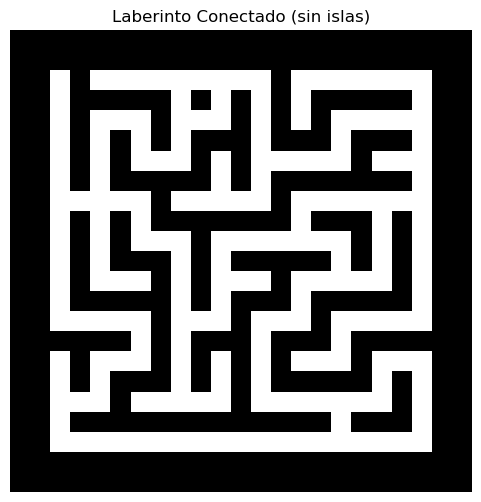

In [10]:
import matplotlib.pyplot as plt

def dibujar_laberinto_estilo(maze, titulo="Laberinto Conectado (sin islas)", escala=20, grosor_borde=1):
    """
    maze: ndarray con 1=libre, 0=pared
    escala: 'zoom' por celda (para ver paredes gruesas sin artefactos)
    grosor_borde: celdas de borde negro adicionales alrededor
    """
    # Añade un marco negro alrededor (borde exterior grueso)
    m = np.pad(maze, pad_width=grosor_borde, mode='constant', constant_values=0)

    # Invertimos para dibujar: 0=negro (pared), 1=blanco (libre)
    # (ya está así, lo dejamos tal cual)
    img = m.copy()

    # Escalar con vecinos más cercanos para que se vean “gruesas” las paredes (sin antialias)
    if escala > 1:
        img = np.kron(img, np.ones((escala, escala), dtype=img.dtype))

    plt.figure(figsize=(6, 6))
    plt.title(titulo)
    plt.imshow(img, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

dibujar_laberinto_estilo(maze, titulo="Laberinto Conectado (sin islas)", escala=22, grosor_borde=1)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 0=pared, 1=libre, 2=visitado, 3=frontera, 4=actual, 6=inicio
cmap = ListedColormap([
    '#000000',  # 0 - pared (negro)
    '#FFFFFF',  # 1 - libre (blanco)
    '#9AD1F7',  # 2 - visitado (azul claro)
    '#FFF59D',  # 3 - frontera (amarillo claro)
    '#FFB74D',  # 4 - actual (naranja)
    '#43A047',  # 6 - inicio (verde)
])

def construir_matriz_estado(maze, visited=set(), frontier=set(), current=None, S=None):
    H, W = maze.shape
    M = maze.copy().astype(np.uint8)  # 0/1
    for (x,y) in visited:
        if M[x,y] == 1:
            M[x,y] = 2
    for (x,y) in frontier:
        if M[x,y] in (1,2):
            M[x,y] = 3
    if current is not None:
        x,y = current
        if M[x,y] in (1,2,3):
            M[x,y] = 4
    if S is not None:
        M[S] = 6
    return M


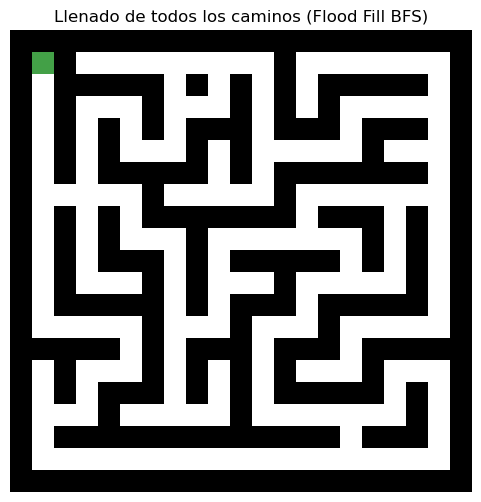

Celdas libres totales llenadas: 204


In [13]:
from collections import deque
from matplotlib import animation

# Tomamos el mismo 'maze' (0=pared, 1=libre) ya generado
assert isinstance(maze, np.ndarray) and maze.ndim == 2

# Punto de inicio: el primero libre cerca de (1,1)
def celda_libre_mas_cercana(maze, target):
    h, w = maze.shape
    vis = np.zeros_like(maze, dtype=bool)
    q = deque([target])
    while q:
        x, y = q.popleft()
        if 0 <= x < h and 0 <= y < w and not vis[x, y]:
            vis[x, y] = True
            if maze[x, y] == 1:
                return (x, y)
            for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                q.append((x+dx, y+dy))
    return target

S = (1, 1)
if maze[S] == 0:
    S = celda_libre_mas_cercana(maze, S)

# --- Flood-fill BFS con traza para animación ---
def flood_fill_frames(maze, start, sample_every=2):
    h, w = maze.shape
    q = deque([start])
    visited = set([start])
    frames = []
    step = 0
    while q:
        current = q.popleft()
        # frontera son los elementos que siguen en cola (copia ligera)
        frontier = set(q)
        # Muestreamos algunos pasos para no generar miles de frames
        if step % sample_every == 0:
            frames.append({
                "visited": visited.copy(),
                "frontier": frontier,
                "current": current
            })
        step += 1

        cx, cy = current
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = cx+dx, cy+dy
            if 0 <= nx < h and 0 <= ny < w and maze[nx, ny] == 1 and (nx, ny) not in visited:
                visited.add((nx, ny))
                q.append((nx, ny))
    # último frame: todo llenado
    frames.append({
        "visited": visited.copy(),
        "frontier": set(),
        "current": None
    })
    return frames

# Generar frames (ajusta sample_every si quieres más/menos fluido)
frames_ff = flood_fill_frames(maze, S, sample_every=1)

# --- Animación ---
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title("Llenado de todos los caminos (Flood Fill BFS)")
ax.axis('off')
frame0 = construir_matriz_estado(maze, visited=set(), frontier=set(), current=None, S=S)
im = ax.imshow(frame0, cmap=cmap, interpolation='nearest')

def init():
    im.set_array(frame0)
    return (im,)

def update(i):
    fr = frames_ff[i]
    M = construir_matriz_estado(
        maze,
        visited=fr["visited"],
        frontier=fr["frontier"],
        current=fr["current"],
        S=S
    )
    im.set_array(M)
    return (im,)

anim = animation.FuncAnimation(
    fig, update, init_func=init,
    frames=len(frames_ff), interval=25, blit=True, repeat=False
)
plt.show()

print(f"Celdas libres totales llenadas: {int(maze.sum())}")


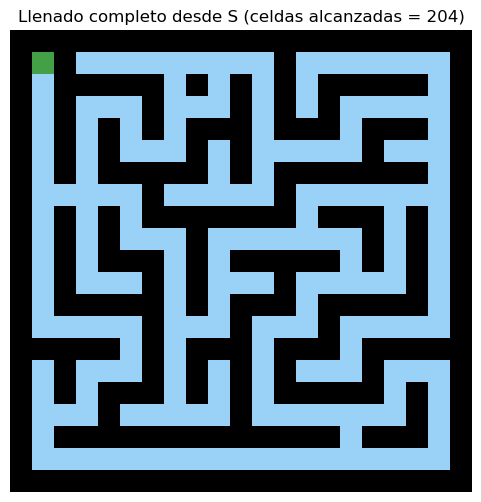

Celdas libres totales en el laberinto: 204
Celdas libres alcanzadas por el llenado: 204


In [14]:
# === Llenar TODOS los caminos conectados (una sola vez, sin animación) ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import deque

# Si ya tienes `maze` (ndarray 0/1), lo usa; si no, lo crea desde tu laberinto en texto.
if 'maze' not in globals():
    maze_chars = np.array([[c for c in fila] for fila in laberinto_conectado], dtype=str)
    maze = (maze_chars == '0').astype(np.uint8)  # 1=libre, 0=pared

def celda_libre_mas_cercana(maze, target):
    h, w = maze.shape
    vis = np.zeros_like(maze, dtype=bool)
    q = deque([target])
    while q:
        x, y = q.popleft()
        if 0 <= x < h and 0 <= y < w and not vis[x, y]:
            vis[x, y] = True
            if maze[x, y] == 1:
                return (x, y)
            for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                q.append((x+dx, y+dy))
    return target

# Punto de inicio (asegurado libre)
S = (1, 1)
if maze[S] == 0:
    S = celda_libre_mas_cercana(maze, S)

# Flood-fill (BFS) para marcar TODAS las celdas libres alcanzables
h, w = maze.shape
visited = np.zeros_like(maze, dtype=bool)
q = deque([S])
visited[S] = True
alcanzadas = 1

while q:
    x, y = q.popleft()
    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
        nx, ny = x+dx, y+dy
        if 0 <= nx < h and 0 <= ny < w and maze[nx, ny] == 1 and not visited[nx, ny]:
            visited[nx, ny] = True
            alcanzadas += 1
            q.append((nx, ny))

# Construir matriz para visualizar: 0=pared, 1=libre, 2=LLENADO, 3=INICIO
M = maze.copy().astype(np.uint8)
M[np.where(visited)] = 2
M[S] = 3

cmap = ListedColormap([
    '#000000',  # 0 - pared (negro)
    '#FFFFFF',  # 1 - libre (blanco)
    '#9AD1F7',  # 2 - llenado (azul claro)
    '#43A047',  # 3 - inicio (verde)
])

plt.figure(figsize=(6,6))
plt.title(f"Llenado completo desde S (celdas alcanzadas = {alcanzadas})")
plt.imshow(M, cmap=cmap, interpolation='nearest')
plt.axis('off')
plt.show()

print(f"Celdas libres totales en el laberinto: {int(maze.sum())}")
print(f"Celdas libres alcanzadas por el llenado: {alcanzadas}")


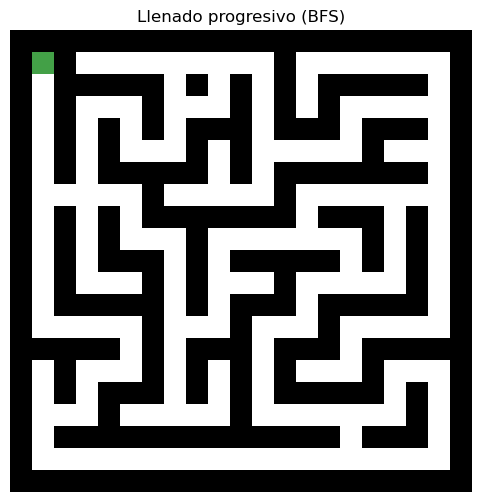

Celdas libres llenadas: 204 / 204


In [15]:
# === Animación de llenado progresivo (BFS) ===
# Colores: pared=negro, libre=blanco, inicio=verde, llenado=naranja
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import deque
import time

# Si ya tienes `maze` (0=pared, 1=libre), lo usa; si no, lo crea desde tu laberinto en texto.
if 'maze' not in globals():
    maze_chars = np.array([[c for c in fila] for fila in laberinto_conectado], dtype=str)
    maze = (maze_chars == '0').astype(np.uint8)  # 1=libre, 0=pared

# Buscar una celda libre cercana a (1,1) para el inicio
def celda_libre_mas_cercana(maze, target):
    from collections import deque
    h, w = maze.shape
    vis = np.zeros_like(maze, dtype=bool)
    q = deque([target])
    while q:
        x, y = q.popleft()
        if 0 <= x < h and 0 <= y < w and not vis[x, y]:
            vis[x, y] = True
            if maze[x, y] == 1:
                return (x, y)
            for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                q.append((x+dx, y+dy))
    return target

S = (1, 1)
if maze[S] == 0:
    S = celda_libre_mas_cercana(maze, S)

# Matriz de estado para pintar:
# 0=pared, 1=libre, 2=LLENADO (naranja), 3=INICIO (verde)
estado = maze.copy().astype(np.uint8)
estado[:] = np.where(maze==1, 1, 0)   # asegurar 0/1
estado[S] = 3

cmap = ListedColormap([
    '#000000',  # 0 - pared (negro)
    '#FFFFFF',  # 1 - libre (blanco)
    '#FFB74D',  # 2 - llenado (naranja)
    '#43A047',  # 3 - inicio (verde)
])

# Parámetros de animación
PAUSA = 0.01     # segundos entre pasos (ajústalo si va muy rápido/lento)
SALTO = 1        # pinta cada 'SALTO' nodos; sube a 2,3... para acelerar

# Preparar BFS
h, w = maze.shape
vis = np.zeros_like(maze, dtype=bool)
q = deque([S])
vis[S] = True

# Plot inicial
plt.figure(figsize=(6,6))
plt.title("Llenado progresivo (BFS)")
im = plt.imshow(estado, cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
plt.axis('off')
plt.pause(0.001)

pasos = 0
while q:
    x, y = q.popleft()

    # Marca como llenado (naranja) todo lo que vayamos alcanzando (sin sobrescribir S)
    if (x, y) != S:
        estado[x, y] = 2

    # Refresca cada 'SALTO' nodos para performance
    if pasos % SALTO == 0:
        im.set_array(estado)
        plt.pause(PAUSA)
    pasos += 1

    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
        nx, ny = x+dx, y+dy
        if 0 <= nx < h and 0 <= ny < w and maze[nx, ny] == 1 and not vis[nx, ny]:
            vis[nx, ny] = True
            q.append((nx, ny))

# Frame final (por si el último paso no refrescó)
im.set_array(estado)
plt.pause(0.5)
print(f"Celdas libres llenadas: {vis.sum()} / {int(maze.sum())}")


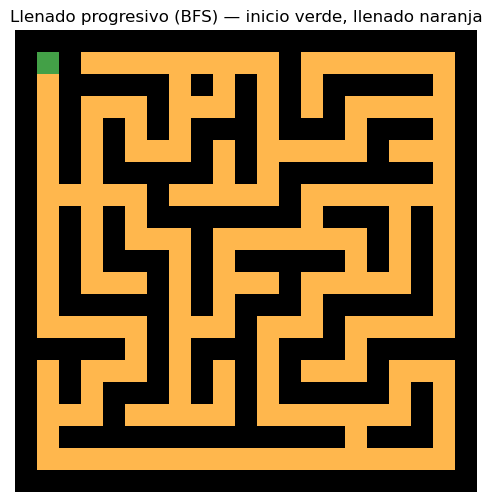

Celdas libres totales: 204
Celdas alcanzadas y llenadas: 204


In [16]:
# === Animación ROBUSTA del llenado (BFS) con clear_output ===
# Colores: pared=negro, libre=blanco, inicio=verde, llenado=naranja

# Asegura backend visible en cuadernos
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import deque
from IPython.display import display, clear_output
import time

# 1) Asegurar que tenemos 'maze' (0=pared, 1=libre)
if 'maze' not in globals():
    # Convertir desde tu laberinto en texto (laberinto_conectado con '0' libres y '1' paredes)
    maze_chars = np.array([[c for c in fila] for fila in laberinto_conectado], dtype=str)
    maze = (maze_chars == '0').astype(np.uint8)  # 1=libre, 0=pared

# 2) Elegir inicio libre cerca de (1,1)
def celda_libre_mas_cercana(maze, target):
    h, w = maze.shape
    vis = np.zeros_like(maze, dtype=bool)
    q = deque([target])
    while q:
        x, y = q.popleft()
        if 0 <= x < h and 0 <= y < w and not vis[x, y]:
            vis[x, y] = True
            if maze[x, y] == 1:
                return (x, y)
            for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                q.append((x+dx, y+dy))
    return target

S = (1, 1)
if maze[S] == 0:
    S = celda_libre_mas_cercana(maze, S)

# 3) Estado visual:
# 0=pared, 1=libre, 2=LLENADO (naranja), 3=INICIO (verde)
estado = np.where(maze==1, 1, 0).astype(np.uint8)
estado[S] = 3

cmap = ListedColormap([
    '#000000',  # 0 - pared (negro)
    '#FFFFFF',  # 1 - libre (blanco)
    '#FFB74D',  # 2 - llenado (naranja)
    '#43A047',  # 3 - inicio (verde)
])

# 4) Parámetros de animación (ajusta si va rápido/lento)
REFRESH_EACH = 2   # refrescar cada N nodos (sube para ir más rápido)
SLEEP = 0.01       # pausa entre refrescos (segundos)

# 5) BFS que realmente llena TODO el componente conectado
h, w = maze.shape
vis = np.zeros_like(maze, dtype=bool)
q = deque([S])
vis[S] = True

# Figura inicial
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title("Llenado progresivo (BFS) — inicio verde, llenado naranja")
ax.axis('off')
im = ax.imshow(estado, cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
display(fig)

pasos = 0
while q:
    x, y = q.popleft()

    # pinto naranja lo visitado (sin pisar el inicio)
    if (x, y) != S and estado[x, y] != 2:
        estado[x, y] = 2

    # expandir
    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
        nx, ny = x+dx, y+dy
        if 0 <= nx < h and 0 <= ny < w and maze[nx, ny] == 1 and not vis[nx, ny]:
            vis[nx, ny] = True
            q.append((nx, ny))

    # refrescar pantalla cada cuantos pasos
    if pasos % REFRESH_EACH == 0:
        im.set_data(estado)
        clear_output(wait=True)
        display(fig)
        time.sleep(SLEEP)
    pasos += 1

# 6) Asegurar que TODO quedó pintado naranja (por si algún paso no refrescó)
estado[(vis) & (estado != 3)] = 2
im.set_data(estado)
clear_output(wait=True)
display(fig)

print(f"Celdas libres totales: {int(maze.sum())}")
print(f"Celdas alcanzadas y llenadas: {int(vis.sum())}")
if vis.sum() < maze.sum():
    print("Aviso: hay celdas libres no conectadas al inicio (otro componente).")
